Let's generate N time discrete series, each consisting of T observations of a random variable X.

First, we load the necessary python packages.
                    

In [23]:
# Check python version
import sys
print("Python is:", sys.version)

# Import matplotlib and numpy
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib is:", matplotlib.__version__)

import numpy as np
print("numpy is:", np.__version__)

import random
from scipy.stats import triang
from scipy.stats import norm
from scipy.stats import truncnorm

%matplotlib inline

Python is: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Matplotlib is: 3.1.1
numpy is: 1.17.2


Next, we generate the series of random numbers. $N$ is the number of different series, and $T$ specifies how many observation we have in each series.

We also set the range of the distribution we will consider [x_min, x_max], and the number of bins, n_bins, into which we will split this range. 

In [24]:
N=5000
T=10

x_min=0
x_max=1
n_bins=20
bin_width=(x_max-x_min)/n_bins

X=np.zeros((N,T))
for i in range(0,N):
    for j in range(0,T):
        X[i][j]=np.random.triangular(x_min,(x_min+x_max)/2,x_max)
#        X[i][j]=np.random.normal(0,1)



Next, we

1. Count observations in each bin, for each of the N time series, yielding N histograms.

2. Estimate the uncertainty in the bin counts as the standard deviation across all time series.

3. Construct the decision weight desnity $w$ by adding the uncertainty to each count, dividing by the total observations, and normalising.

4. Construct the CDF of the decision weights.

5. Find the CDF of the reference distribution we used to generate the data.

In [25]:
#1 count
n=np.empty((N,n_bins))

for series in range(0,N):
    n[series][:]=np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[0]

In [26]:
#2 find uncertainty
uncertainty=np.std(n,0)

In [27]:
#3 construct decision weights and normalize
#narb=n[0] # choose an arbitrary set of counts
#narb=np.median(n,0)
narb=np.mean(n,0)
phat=narb/T # estimated desnity
wraw=(narb+uncertainty)/T # unnormalised decision weight
wmass=np.sum(wraw)*bin_width # unnormalised mass
w=wraw/wmass # normalised decision weight

In [28]:
#4 find decision weight CDF
Fw=np.cumsum(w)*bin_width
Fw

array([0.01172465, 0.03490895, 0.06755124, 0.108651  , 0.15656889,
       0.21171487, 0.27409641, 0.34288747, 0.41769665, 0.49838643,
       0.57883877, 0.65618947, 0.72514816, 0.78814055, 0.84375694,
       0.89206047, 0.93351327, 0.96566388, 0.98831486, 1.        ])

In [31]:
#5 find reference CDF
x_bins=np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[1] # bin edges
x_bins=x_bins[1:] # remove first bin edge
#Fp=triang.cdf(np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[1],.5,0,1)
#Fp=norm.cdf(x_bins,0,1)
Fp=triang.cdf(x_bins,0,1)
Fp

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

Finally, we display the resulting ``probability weighting,'' in the usual way and recover the inverse-S curve... or do we?

ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

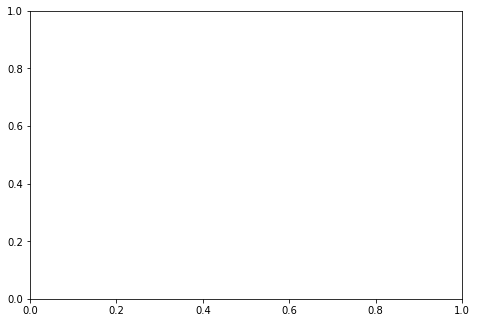

In [30]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(Fp,Fw,'b',label='')
ax.plot(Fp,Fp,'r',label='')
ax.legend()
ax.set_xlabel(r'$F_p$')
ax.set_ylabel(r'$F_w$')
plt.show() 

In [21]:
Fw

array([7.36666990e-04, 1.78438692e-03, 3.91968844e-03, 9.60512847e-03,
       2.33974988e-02, 5.16878339e-02, 1.07851207e-01, 2.01166068e-01,
       3.37042981e-01, 5.01017065e-01, 6.61239053e-01, 7.96990040e-01,
       8.90582945e-01, 9.46406055e-01, 9.76065571e-01, 9.89828909e-01,
       9.96315465e-01, 9.98952280e-01, 1.00000000e+00, 1.00000000e+00])

In [22]:
Fp

array([3.39767312e-06, 3.16712418e-05, 2.32629079e-04, 1.34989803e-03,
       6.20966533e-03, 2.27501319e-02, 6.68072013e-02, 1.58655254e-01,
       3.08537539e-01, 5.00000000e-01, 6.91462461e-01, 8.41344746e-01,
       9.33192799e-01, 9.77249868e-01, 9.93790335e-01, 9.98650102e-01,
       9.99767371e-01, 9.99968329e-01, 9.99996602e-01, 9.99999713e-01])